# Test the bandstructure functionality
There are many things to be thoroughly tested in the bandstructure functionality. This includes the Hamiltonians (which have to match against their low-energy counterparts) and the unit cell duplicator, which is used to build nanoribbons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '/home/simao/projects_sync/codes/tight-binding-test/src/')
import band_structure as bs

# Testing Hamiltonians

In [2]:
# General information about the graphene lattice

# These lines are required to find the reciprocal vectors
GR = bs.band_structure()
GR.DEBUG = 0 # Debug flag. Set to 1 to get debug information

# Lattice properties and primitive vectors (already defined reciprocal lattice vectors)
acc = 1.0
a  = np.sqrt(3)*acc
a1 = a*np.array([np.sqrt(3)/2, 0.5])
a2 = a*np.array([0,1])
prims = [a1,  a2]

GR.set_primitive2(a1,a2) 
b1 = GR.b1
b2 = GR.b2


# Information about the orbitals
pA = acc*np.array([0,0])
pB = acc*np.array([1,0])*0

# Express positions in terms of primitive vectors
pB1 = np.dot(pB, b1)/np.pi/2
pB2 = np.dot(pB, b2)/np.pi/2
pBp = np.array([pB1,pB2])
print(pBp, pBp[0]*a1 + pBp[1]*a2)

orbs = ["Au","Ad","Bu","Bd"]
pos  = [  pA*1.0,  pA*1.0, pBp*1.0, pBp*1.0]
Norbs = len(orbs)


[0. 0.] [0. 0.]


In [3]:
# Important points in the FBZ
K  = np.array([1.0/3.0, 2.0/3.0])
Kp = np.array([2.0/3.0, 1.0/3.0])
G  = np.array([    0.0,     0.0])
M  = np.array([    0.5,     0.0])

# Define the Pauli matrices
pauli_0 = np.zeros([2,2], dtype=complex)
pauli_x = np.zeros([2,2], dtype=complex)
pauli_y = np.zeros([2,2], dtype=complex)
pauli_z = np.zeros([2,2], dtype=complex)

pauli_0[0,0] = 1
pauli_0[1,1] = 1

pauli_x[1,0] = 1
pauli_x[0,1] = 1

pauli_y[1,0] =  1j
pauli_y[0,1] = -1j

pauli_z[0,0] =  1
pauli_z[1,1] = -1

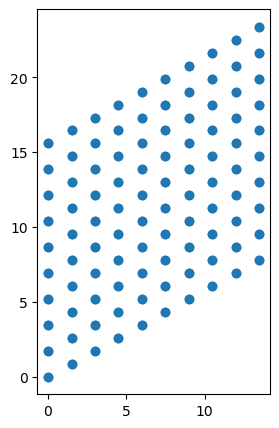

In [4]:
# Check lattice
lista = []
for i in range(10):
    for j in range(10):
        for p in [pA,pB]:
            r = i*a1 + j*a2 + p
            lista.append(r)
x = [r[0] for r in lista]
y = [r[1] for r in lista]

fig, axs = plt.subplots(1,1,figsize=(3,5))
axs.scatter(x,y)
plt.show()

In [5]:


def reorder_hops(hops):
    reordered_hops = []
    for hop in hops:
        fro, to, i0, i1, value = hop    
        reordered = [[i0,i1], fro, to, value]
        reordered_hops.append(reordered)   
    return reordered_hops

def set_baseclass():
    GR = bs.band_structure()
    GR.DEBUG = 0 # Debug flag. Set to 1 to get debug information
    GR.set_primitive2(a1,a2)
    GR.set_orbs(orbs, pos)
    return GR

In [6]:

def test_bands(τ,α, GR, lin):
    point = K*1.0
    if τ == -1: point = Kp*1.0
    print(point)

    # Parametrize the path to K
    Gα = G + (point-G)*α
    Mα = M + (point-M)*α

    GR.set_kpath([Gα,point,Mα],100)

    bands1 = np.zeros([Norbs, GR.Nk])
    bands2 = np.zeros([Norbs, GR.Nk])
    dif    = np.zeros([GR.Nk])

    for kk,k in enumerate(GR.ks):
        # print(k)
        H1 = GR.get_Hk(k)
        H2 = lin(τ, k)
        dH = np.linalg.norm(H1 - H2)

        vals1 = np.linalg.eigvals(H1)
        vals2 = np.linalg.eigvals(H2)

        bands1[:,kk] = np.real(vals1)
        bands2[:,kk] = np.real(vals2)
        dif[kk] = dH
        
    return bands1, bands2, dif


## Regular graphene hoppings

In [7]:
def Hlin_graphene(t, τ, k12):
    # k12 is the wavevector in units of b1 and b2
    # τ is the valley index. t=1: K point, t=-1: K' point
    
    dK = k12*1.0
    if τ ==  1: dK -= K*1.0  # distance to K point
    if τ == -1: dK -= Kp*1.0 # distance to K' point
    
    # Convert from units of b1,b2 to kx,ky
    kxr, kyr = GR.b1*dK[0] + GR.b2*dK[1]
    
    # Rotate
    # kx = -kyr
    # ky = kxr    
    # A = τ*kx*pauli_x - ky*pauli_y
    
    # Or just use directly
    A = kxr*pauli_y + τ*kyr*pauli_x
    
    
    A *= 3/2
    
    mat = np.zeros([4,4], dtype=complex)
    mat[0,2] = A[0,1]*1.0
    mat[1,3] = A[0,1]*1.0
    mat[2,0] = A[1,0]*1.0
    mat[3,1] = A[1,0]*1.0
    
    
    return mat
    
    

In [8]:

GR = set_baseclass()

# Build the hoppings from the tight-binding functionality
t = -1
hops = bs.graphene(t)
reordered_hops = reorder_hops(hops)
GR.set_bonds(reordered_hops)
print(reordered_hops)

[[[0, 0], 'Bu', 'Au', -1], [[1, 0], 'Bu', 'Au', -1], [[1, -1], 'Bu', 'Au', -1], [[0, 0], 'Bd', 'Ad', -1], [[1, 0], 'Bd', 'Ad', -1], [[1, -1], 'Bd', 'Ad', -1]]


In [9]:
τ = -1

point = K*1.0
if τ == -1: point = Kp*1.0
print(point)

# Test a few values of k
kx = -0.001
ky = 0.0001
k = np.array([kx,ky])
# print(k)

k1 = np.dot(k,a1)/np.pi/2
k2 = np.dot(k,a2)/np.pi/2
kk = np.array([k1,k2])

k = point + kk
print(point,k,kk)


H1 = GR.get_Hk(k)
H2 = Hlin_graphene(t,τ,k)

np.set_printoptions(precision=5)

print(H1,"\n")
print(H2)
# print(H1)

[0.66666667 0.33333333]
[0.66666667 0.33333333] [0.66644172 0.3333609 ] [-2.24949192e-04  2.75664448e-05]
[[ 0.     +0.j      0.     +0.j     -0.00015+0.0015j  0.     +0.j    ]
 [ 0.     +0.j      0.     +0.j      0.     +0.j     -0.00015+0.0015j]
 [-0.00015-0.0015j  0.     +0.j      0.     +0.j      0.     +0.j    ]
 [ 0.     +0.j     -0.00015-0.0015j  0.     +0.j      0.     +0.j    ]] 

[[ 0.     +0.j      0.     +0.j     -0.00015+0.0015j  0.     +0.j    ]
 [ 0.     +0.j      0.     +0.j      0.     +0.j     -0.00015+0.0015j]
 [-0.00015-0.0015j  0.     +0.j      0.     +0.j      0.     +0.j    ]
 [ 0.     +0.j     -0.00015-0.0015j  0.     +0.j      0.     +0.j    ]]


[0.33333 0.66667]
[0.33333 0.66667]
[0.66667 0.33333]
[0.66667 0.33333]


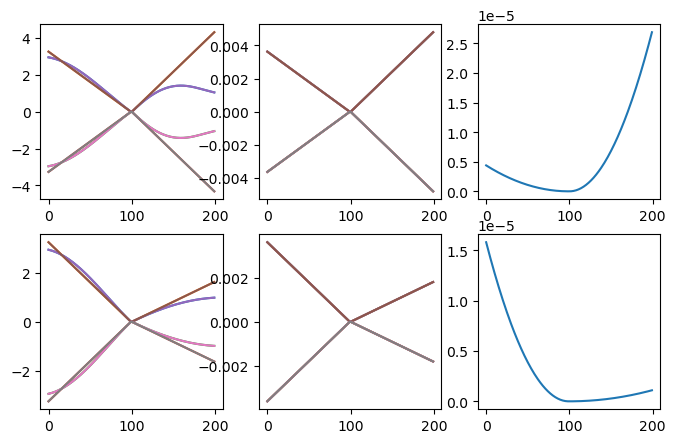

In [10]:
# See if the band structure matches for the K and K' points
# If this is correct, the error should scale quadratically with the difference of α to 1

def lin(τ,k):
    return Hlin_graphene(t, τ, k)

fig, axs = plt.subplots(2,3,figsize=(8,5))

for i,τ in enumerate([1,-1]):
    for j,α in enumerate([0.1, 0.999]):
        bands1, bands2, dif = test_bands(τ, α, GR, lin)
        # bands1, bands2, dif = get_bands_graphene(τ, α)

        for n in range(Norbs):
            axs[i,j].plot(bands1[n,:])
            axs[i,j].plot(bands2[n,:]) 
            
    # dif is the norm2 difference between the two Hamiltonians
    axs[i,2].plot(dif)
plt.show()


## Rashba SOC Hamiltonian

In [11]:
def Hlin_rashba(λR, ϕ, τ, k12):
    # τ is the valley index. t=1: K point, t=-1: K' point
        
    dK = k12*1.0
    if τ ==  1: dK -= K*1.0  # distance to K point
    if τ == -1: dK -= Kp*1.0 # distance to K' point
    
    # Convert from units of b1,b2 to kx,ky
    kx, ky = GR.b1*dK[0] + GR.b2*dK[1]
    
    # Spin rotation matrix e^i Sz ϕ
    rot  = np.diag([np.exp(1j*ϕ/2), np.exp(-1j*ϕ/2)])
    rotr = rot.conjugate()
    
    # Calculate the tensor products
    σxsx = np.kron(pauli_x, rot@pauli_x@rotr)
    σysy = np.kron(pauli_y, rot@pauli_y@rotr)
    σxsy = np.kron(pauli_x, rot@pauli_y@rotr)
    σysx = np.kron(pauli_y, rot@pauli_x@rotr)

    mat1 = -τ*σxsx +     σysy
    mat2 =    σxsy + 3*τ*σysx
    mat3 =    σxsx +   τ*σysy
    
    return -λR*(mat1 - 0.5*kx*mat2 + 0.5*ky*mat3)
    

In [12]:
GR = set_baseclass()

# Build the hoppings from the tight-binding functionality
λR = 1.0
ϕ  = 0.9

hops = bs.rashba_phase(λR, ϕ)
reordered_hops = reorder_hops(hops)
GR.set_bonds(reordered_hops)
print(reordered_hops)

[[[0, 0], 'Au', 'Bd', (0.41440664551377626+0.5222179397516555j)], [[-1, 0], 'Au', 'Bd', (-0.6594573248937934+0.097777712636195j)], [[-1, 1], 'Au', 'Bd', (0.24505067938001707-0.6199956523878505j)], [[0, 0], 'Ad', 'Bu', (-0.41440664551377626+0.5222179397516555j)], [[-1, 0], 'Ad', 'Bu', (0.6594573248937934+0.097777712636195j)], [[-1, 1], 'Ad', 'Bu', (-0.24505067938001707-0.6199956523878505j)]]


In [13]:
τ = 1

point = K*1.0
if τ == -1: point = Kp*1.0
print(point)

# Test a few values of k
kx =  -0.002
ky =   0.001
k = np.array([kx,ky])
# print(k)

k1 = np.dot(k,a1)/np.pi/2
k2 = np.dot(k,a2)/np.pi/2
kk = np.array([k1,k2])

k = point + kk
print(point,k,kk)

H1 = GR.get_Hk(k)
H2 = Hlin_rashba(λR,ϕ,τ,k)
# h1 = H1[0,3]
# h2 = H2[0,3]

np.set_printoptions(precision=5, linewidth=200)

print(H1)
print(H2)
print(np.linalg.norm(H1-H2))
# print(h2)
# print(H1)

[0.33333 0.66667]
[0.33333 0.66667] [0.33299 0.66694] [-0.00034  0.00028]
[[0.00000e+00+0.j      0.00000e+00+0.j      0.00000e+00+0.j      1.24008e+00+1.56914j]
 [0.00000e+00+0.j      0.00000e+00+0.j      9.40674e-04+0.00203j 0.00000e+00+0.j     ]
 [0.00000e+00+0.j      9.40674e-04-0.00203j 0.00000e+00+0.j      0.00000e+00+0.j     ]
 [1.24008e+00-1.56914j 0.00000e+00+0.j      0.00000e+00+0.j      0.00000e+00+0.j     ]]
[[-0.00000e+00+0.j      -0.00000e+00+0.j      -0.00000e+00+0.j       1.24009e+00+1.56914j]
 [-0.00000e+00+0.j      -0.00000e+00+0.j       9.45044e-04+0.00203j -0.00000e+00+0.j     ]
 [-0.00000e+00+0.j       9.45044e-04-0.00203j -0.00000e+00+0.j      -0.00000e+00+0.j     ]
 [ 1.24009e+00-1.56914j -0.00000e+00+0.j      -0.00000e+00+0.j      -0.00000e+00+0.j     ]]
1.1117993503029159e-05


[0.33333 0.66667]
[0.33333 0.66667]
[0.66667 0.33333]
[0.66667 0.33333]


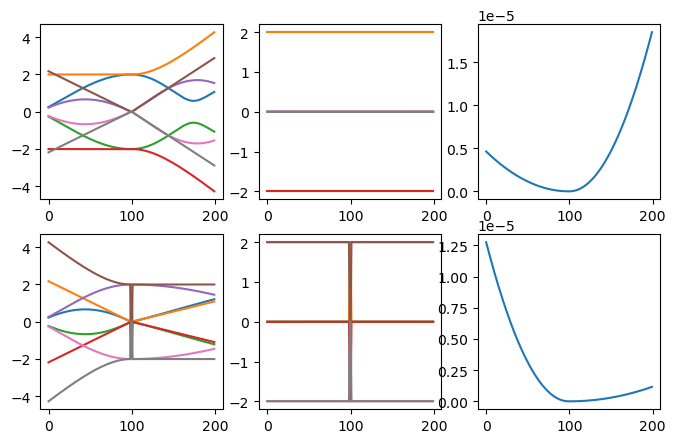

In [14]:
# See if the band structure matches for the K and K' points
# If this is correct, the error should scale quadratically with the difference of α to 1

def lin(τ,k):
    return Hlin_rashba(λR, ϕ, τ, k)

fig, axs = plt.subplots(2,3,figsize=(8,5))

for i,τ in enumerate([1,-1]):
    for j,α in enumerate([0.1, 0.999]):
        bands1, bands2, dif = test_bands(τ, α, GR, lin)

        for n in range(Norbs):
            axs[i,j].plot(bands1[n,:])
            axs[i,j].plot(bands2[n,:]) 
            
    # dif is the norm2 difference between the two Hamiltonians
    axs[i,2].plot(dif)
plt.show()


## Kane-Mele Hamiltonian

In [15]:

def Hlin_KaneMele(λIA, λIB, τ):
    # τ is the valley index. t=1: K point, t=-1: K' point
    
    σp = 0.5*(pauli_z + pauli_0)
    σm = 0.5*(pauli_z - pauli_0)
    
    σpsz = np.kron(σp, pauli_z)
    σmsz = np.kron(σm, pauli_z)
    
    return τ*(λIA*σpsz + λIB*σmsz)

In [16]:
GR = set_baseclass()

# Build the hoppings from the tight-binding functionality
λIA = 0.3
λIB = 1.0

hops = bs.KaneMele(λIA, λIB)
reordered_hops = reorder_hops(hops)
GR.set_bonds(reordered_hops)
# print(reordered_hops)

In [17]:
τ = 1

point = K*1.0
if τ == -1: point = Kp*1.0
print(point)

# Test a few values of k
kx =  -0.02
ky =   0.01
k = np.array([kx,ky])
# print(k)

k1 = np.dot(k,a1)/np.pi/2
k2 = np.dot(k,a2)/np.pi/2
kk = np.array([k1,k2])

k = point + kk
print(point,k,kk)

H1 = GR.get_Hk(k)
H2 = Hlin_KaneMele(λIA, λIB, τ)
# h1 = H1[0,3]
# h2 = H2[0,3]

np.set_printoptions(precision=5, linewidth=200)

print(H1,"\n")
print(H2)
print(np.linalg.norm(H1-H2))
# print(h2)
# print(H1)

[0.33333 0.66667]
[0.33333 0.66667] [0.32994 0.66942] [-0.0034   0.00276]
[[ 0.29989+0.j  0.     +0.j  0.     +0.j  0.     +0.j]
 [ 0.     +0.j -0.29989+0.j  0.     +0.j  0.     +0.j]
 [ 0.     +0.j  0.     +0.j -0.99963+0.j  0.     +0.j]
 [ 0.     +0.j  0.     +0.j  0.     +0.j  0.99963+0.j]] 

[[ 0.3+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.3+0.j  0. +0.j -0. +0.j]
 [ 0. +0.j  0. +0.j -1. +0.j  0. +0.j]
 [ 0. +0.j -0. +0.j  0. +0.j  1. +0.j]]
0.0005515989866928852


[0.33333 0.66667]
[0.33333 0.66667]
[0.66667 0.33333]
[0.66667 0.33333]


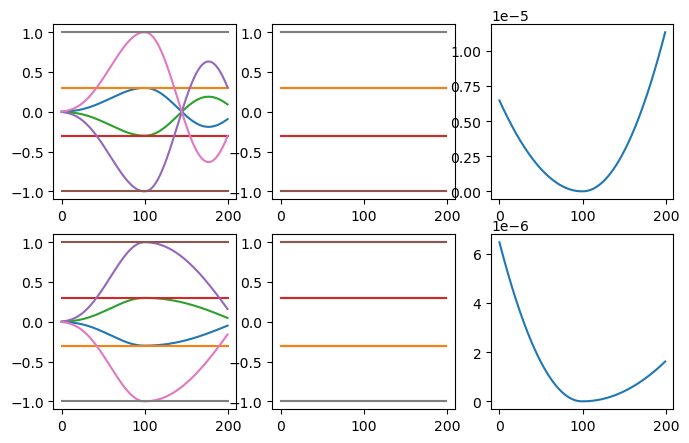

In [18]:
# See if the band structure matches for the K and K' points
# If this is correct, the error should scale quadratically with the difference of α to 1

def lin(τ,k):
    return Hlin_KaneMele(λIA, λIB, τ)

fig, axs = plt.subplots(2,3,figsize=(8,5))

for i,τ in enumerate([1,-1]):
    for j,α in enumerate([0.1, 0.999]):
        bands1, bands2, dif = test_bands(τ, α, GR, lin)

        for n in range(Norbs):
            axs[i,j].plot(bands1[n,:])
            axs[i,j].plot(bands2[n,:]) 
            
    # dif is the norm2 difference between the two Hamiltonians
    axs[i,2].plot(dif)
plt.show()


## Sublattice asymmetry Hamiltonian

In [19]:

def Hlin_sublattice_dist(Δ):
    σzs0 = np.kron(pauli_z, pauli_0)
    return Δ*σzs0

In [20]:
GR = set_baseclass()

# Build the hoppings from the tight-binding functionality
Δ = 1.0
hops = bs.sublattice_dist(Δ)
reordered_hops = reorder_hops(hops)
GR.set_bonds(reordered_hops)

In [21]:

# Test a few values of k
kx =  -0.2
ky =   0.1
k = np.array([kx,ky])
# print(k)

k1 = np.dot(k,a1)/np.pi/2
k2 = np.dot(k,a2)/np.pi/2
k = np.array([k1,k2])

H1 = GR.get_Hk(k)
H2 = Hlin_sublattice_dist(Δ)

np.set_printoptions(precision=5, linewidth=200)

print(H1,"\n")
print(H2)
print(np.linalg.norm(H1-H2))

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]] 

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j -1.+0.j]]
0.0


# Thorougly testing unit cell duplicator
Band structure of duplicated unit cell has to match against the non-duplicated one

In [22]:
# def remove_cc(hop_list):
#     all_hops = hop_list.copy()
    
#     pops = True
#     while pops:
#         pops = False
#         for hop in all_hops:
#             o1,o2,n,m,t = hop
#             if o1==o2 and n==0 and m==0: continue
#             cc = [o2,o1,-n,-m,np.conj(t)]

#             if cc in all_hops:
#                 all_hops.remove(cc)
#                 pops = True
#                 break

#     return all_hops


## Test with square lattice

In [23]:
# Lattice properties and primitive vectors (already defined reciprocal lattice vectors)
a1 = np.array([1,0])
a2 = np.array([0,1])
prims = [a1,  a2]

# GR.set_primitive2(a1,a2) 
b1 = GR.b1
b2 = GR.b2

# Information about the orbitals
pA = np.array([0,0])

# Express positions in terms of primitive vectors
pA1 = np.dot(pA, b1)/np.pi/2
pA2 = np.dot(pA, b2)/np.pi/2
pAp = np.array([pA1,pA2])
print(pAp, pAp[0]*a1 + pAp[1]*a2)

orbs = ["A"]
pos  = [pA*1.0]
Norbs = len(orbs)


[0. 0.] [0. 0.]


In [24]:
t = -1
hops = []
hops.append(["A", "A", 1, 0, t])
hops.append(["A", "A", 0, 1, t])
rehops = reorder_hops(hops)
print(rehops)

duplicator = bs.hop_utils()
duplicator.set_prims(prims)
duplicator.set_orbs(orbs, pos)
duplicator.set_hops(hops)

# join unit cell [0,0] with [1,0]
join = [1,0]

# New primitive vectors
A1 = [2,0]
A2 = [0,1]

duplicator.set_duplication_rules(join, A1, A2)
duplicator.duplicate_orbs()
duplicator.duplicate_hops()

new_A1 = A1[0]*a1 + A1[1]*a2
new_A2 = A2[0]*a1 + A2[1]*a2
new_prims = [new_A1, new_A2]

ham_struct = [duplicator.new_orbs_dic, duplicator.new_pos, new_prims, duplicator.new_hops]

newhops_nocc = bs.remove_cc(duplicator.new_hops)
new_rehops = reorder_hops(newhops_nocc)

[[[1, 0], 'A', 'A', -1], [[0, 1], 'A', 'A', -1]]


In [25]:
print(rehops)
print()
print(new_rehops)

[[[1, 0], 'A', 'A', -1], [[0, 1], 'A', 'A', -1]]

[[[0, 0], 'A1', 'A2', -1], [[1, 0], 'A2', 'A1', -1], [[0, 1], 'A1', 'A1', -1], [[0, 1], 'A2', 'A2', -1]]


In [26]:
GR = bs.band_structure()
GR.DEBUG = 0
GR.set_primitive2(a1,a2)
GR.set_orbs(orbs, pos)
GR.set_bonds(rehops)
b1 = GR.b1
b2 = GR.b2

GR2 = bs.band_structure()
GR2.DEBUG = 0 
GR2.set_primitive2(A1,A2)
GR2.set_orbs(duplicator.new_orbs, duplicator.new_pos)
GR2.set_bonds(new_rehops)
B1 = GR.b1
B2 = GR.b2


In [27]:
# Test a few values of k
# point = K*1.0
# Kxy = point[0]*b1 + point[1]*b2
# kx,ky = Kxy
kx = 2.3
ky = 1.0
k  = np.array([kx,ky])
print(k)

# convert from kx,ky to units of reciprocal primitive vectors in a
k1 = np.dot(k,a1)/np.pi/2
k2 = np.dot(k,a2)/np.pi/2
ka = np.array([k1,k2])*1.0

# convert from kx,ky to units of reciprocal primitive vectors in A
k1 = np.dot(k,A1)/np.pi/2
k2 = np.dot(k,A2)/np.pi/2
kA = np.array([k1,k2])

H1  =  GR.get_Hk(ka)
H1t =  GR.get_Hk(ka+np.array([0.5,0]))
H2  = GR2.get_Hk(kA)

np.set_printoptions(precision=2)

for h in [H1, H1t, H2]:
    vals = np.linalg.eigvalsh(h)
    print(vals)
    

[2.3 1. ]
[0.25]
[-2.41]
[-2.41  0.25]


## Test with more complicated lattice structure: Graphene

In [28]:

GR = bs.band_structure()
GR.DEBUG = 0 # Debug flag. Set to 1 to get debug information

# Lattice properties and primitive vectors (already defined reciprocal lattice vectors)
acc = 1.0
a  = np.sqrt(3)*acc
a1 = a*np.array([np.sqrt(3)/2, 0.5])
a2 = a*np.array([0,1])
prims = [a1,  a2]

GR.set_primitive2(a1,a2) 
b1 = GR.b1
b2 = GR.b2

# Information about the orbitals
pA = acc*np.array([0,0])
pB = acc*np.array([1,0])

# Express positions in terms of primitive vectors
pB1 = np.dot(pB, b1)/np.pi/2
pB2 = np.dot(pB, b2)/np.pi/2
pBp = np.array([pB1,pB2])
print(pBp, pBp[0]*a1 + pBp[1]*a2)


[ 0.67 -0.33] [1. 0.]


In [29]:
# This cell is the only one that specifies hoppings and orbitals
# all else is completely general

# Simple graphene
# orbs = ["A","B"]
# pos  = [  pA*1.0, pBp*1.0]
# Norbs = len(orbs)

# t = -1.0
# hops = bs.graphene_simple(t)


# Graphene with more couplings and spin
orbs  = ["Au",   "Ad",   "Bu",    "Bd"]
pos   = [pA*1.0, pA*1.0, pBp*1.0, pBp*1.0]
Norbs = len(orbs)

t   = -1.0
λR  =  0.3
ϕ   =  1.9
λIA = -0.7
λIB =  1.2
Δ   =  0.5

hops  = []
hops  = bs.graphene(t)
hops += bs.rashba_phase(λR, ϕ)
hops += bs.KaneMele(λIA, λIB)
hops += bs.sublattice_dist(Δ)

In [30]:
rehops = reorder_hops(hops)

duplicator = bs.hop_utils()
duplicator.set_prims(prims)
duplicator.set_orbs(orbs, pos)
duplicator.set_hops(hops)

# join unit cell [0,0] with [1,0]
join = [1,0]

# New primitive vectors
A1 = [2,-1]
A2 = [0, 1]

duplicator.set_duplication_rules(join, A1, A2)
duplicator.duplicate_orbs()
duplicator.duplicate_hops()

new_A1 = A1[0]*a1 + A1[1]*a2
new_A2 = A2[0]*a1 + A2[1]*a2
new_prims = [new_A1, new_A2]

ham_struct = [duplicator.new_orbs_dic, duplicator.new_pos, new_prims, duplicator.new_hops]

# Remove complex conjugates and reorder hops
newhops_nocc = bs.remove_cc(duplicator.new_hops)
new_rehops   = reorder_hops(newhops_nocc)

In [40]:
for hop in hops:
    if hop[0] == hop[1]:
        print(hop)

print()
for hop in duplicator.new_hops:
    if hop[0] == hop[1]:
        print(hop)


['Au', 'Au', 1, 0, 0.13471506281091267j]
['Au', 'Au', 0, 1, -0.13471506281091267j]
['Au', 'Au', -1, 1, 0.13471506281091267j]
['Ad', 'Ad', 1, 0, (-0-0.13471506281091267j)]
['Ad', 'Ad', 0, 1, 0.13471506281091267j]
['Ad', 'Ad', -1, 1, (-0-0.13471506281091267j)]
['Bu', 'Bu', 1, 0, 0.2309401076758503j]
['Bu', 'Bu', 0, 1, -0.2309401076758503j]
['Bu', 'Bu', -1, 1, 0.2309401076758503j]
['Bd', 'Bd', 1, 0, (-0-0.2309401076758503j)]
['Bd', 'Bd', 0, 1, 0.2309401076758503j]
['Bd', 'Bd', -1, 1, (-0-0.2309401076758503j)]
['Au', 'Au', 0, 0, 0.5]
['Ad', 'Ad', 0, 0, 0.5]
['Bu', 'Bu', 0, 0, -0.5]
['Bd', 'Bd', 0, 0, -0.5]

['Au1', 'Au1', 0, 1, -0.13471506281091267j]
['Au2', 'Au2', 0, 1, -0.13471506281091267j]
['Ad1', 'Ad1', 0, 1, 0.13471506281091267j]
['Ad2', 'Ad2', 0, 1, 0.13471506281091267j]
['Bu1', 'Bu1', 0, 1, -0.2309401076758503j]
['Bu2', 'Bu2', 0, 1, -0.2309401076758503j]
['Bd1', 'Bd1', 0, 1, 0.2309401076758503j]
['Bd2', 'Bd2', 0, 1, 0.2309401076758503j]
['Au1', 'Au1', 0, -1, 0.13471506281091267j]
[

In [32]:
GR = bs.band_structure()
GR.DEBUG = 0
GR.set_primitive2(a1,a2)
GR.set_orbs(orbs, pos)
GR.set_bonds(rehops)
b1 = GR.b1
b2 = GR.b2

GR2 = bs.band_structure()
GR2.DEBUG = 0 
GR2.set_primitive2(*new_prims)
GR2.set_orbs(duplicator.new_orbs, duplicator.new_pos)
GR2.set_bonds(new_rehops)
B1 = GR.b1
B2 = GR.b2

print(GR.a1,GR.a2)
print(GR2.a1,GR2.a2)


[1.5  0.87] [0.   1.73]
[3. 0.] [0.   1.73]


In [33]:
# Test a few values of k

kx = 0.0
ky = 0.4
k  = np.array([kx,ky])
print("k_xy",k)

# convert from kx,ky to units of reciprocal primitive vectors in a
k1 = np.dot(k,a1)/np.pi/2
k2 = np.dot(k,a2)/np.pi/2
ka = np.array([k1,k2])*1.0

# convert from kx,ky to units of reciprocal primitive vectors in A
k1 = np.dot(k,new_A1)/np.pi/2
k2 = np.dot(k,new_A2)/np.pi/2
kA = np.array([k1,k2])
print("ka",ka)
print("kA",kA)

H1  =  GR.get_Hk(ka)
H1t =  GR.get_Hk(ka + np.array([0.5,0]))
H2  = GR2.get_Hk(kA)

for h in [H1, H1t, H2]:
    vals = np.linalg.eigvalsh(h)
    print(vals)

k_xy [0.  0.4]
ka [0.06 0.11]
kA [0.   0.11]
[-3.04 -2.81  2.81  3.04]
[-1.6  -0.63  0.73  1.5 ]
[-3.04 -2.81 -1.6  -0.63  0.73  1.5   2.81  3.04]


In [34]:
# Compare a full band structure
NK = 200
klist = np.zeros([NK, 2])
klist[:,0] = np.linspace(0.1,np.pi*2,NK)
klist[:,1] = np.linspace(np.pi,0.2,NK)

bands1 = np.zeros([NK,Norbs])
bands2 = np.zeros([NK,Norbs])
bands3 = np.zeros([NK,Norbs*2])

for kk in range(NK):
    kx,ky = klist[kk,:]
    k  = np.array([kx,ky])

    # convert from kx,ky to units of reciprocal primitive vectors in a
    k1 = np.dot(k,a1)/np.pi/2
    k2 = np.dot(k,a2)/np.pi/2
    ka = np.array([k1,k2])*1.0

    # convert from kx,ky to units of reciprocal primitive vectors in A
    k1 = np.dot(k,new_A1)/np.pi/2
    k2 = np.dot(k,new_A2)/np.pi/2
    kA = np.array([k1,k2])

    H1  =  GR.get_Hk(ka)
    H1t =  GR.get_Hk(ka + np.array([0.5,0]))
    H2  = GR2.get_Hk(kA)

    bands1[kk,:] = np.linalg.eigvalsh(H1)
    bands2[kk,:] = np.linalg.eigvalsh(H1t)
    bands3[kk,:] = np.linalg.eigvalsh(H2)

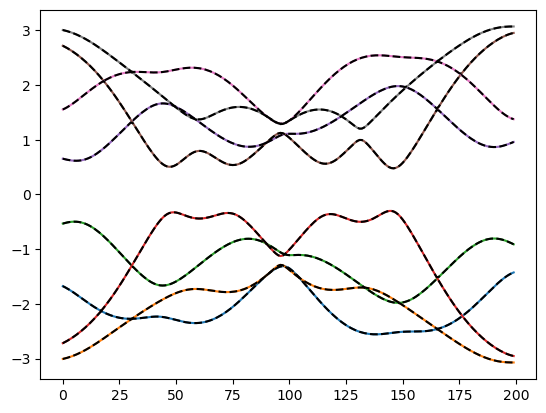

In [35]:
for n in range(Norbs):
    plt.plot(bands1[:,n])
    plt.plot(bands2[:,n])
    
for n in range(Norbs*2):
    plt.plot(bands3[:,n],'k--')
plt.show()